Usando dispositivo: cuda
=== CARGANDO DATOS ===
Datos de entrenamiento: (3680, 20)
Datos de prueba: (520, 19)

Columnas: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

=== INFORMACIÓN BÁSICA ===
Rango de años - Train: 2015 - 2021
Rango de años - Test: 2022 - 2022
Número de barrios únicos en train: 10
Número de barrios únicos en test: 10
Rango de semanas: 1 - 53

=== ESTADÍSTICAS DE LA VARIABLE OBJETIVO (DENGUE) ===
count    3680.000000
mean        2.609511
std         3.523843
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        29.000000
Name: dengue, dtype: float64
Valores faltantes en dengue: 0

=== VALORES FALTANTES ===
Train:
Series([], dtype: int64)

Test:
Series([], dtype: int64)


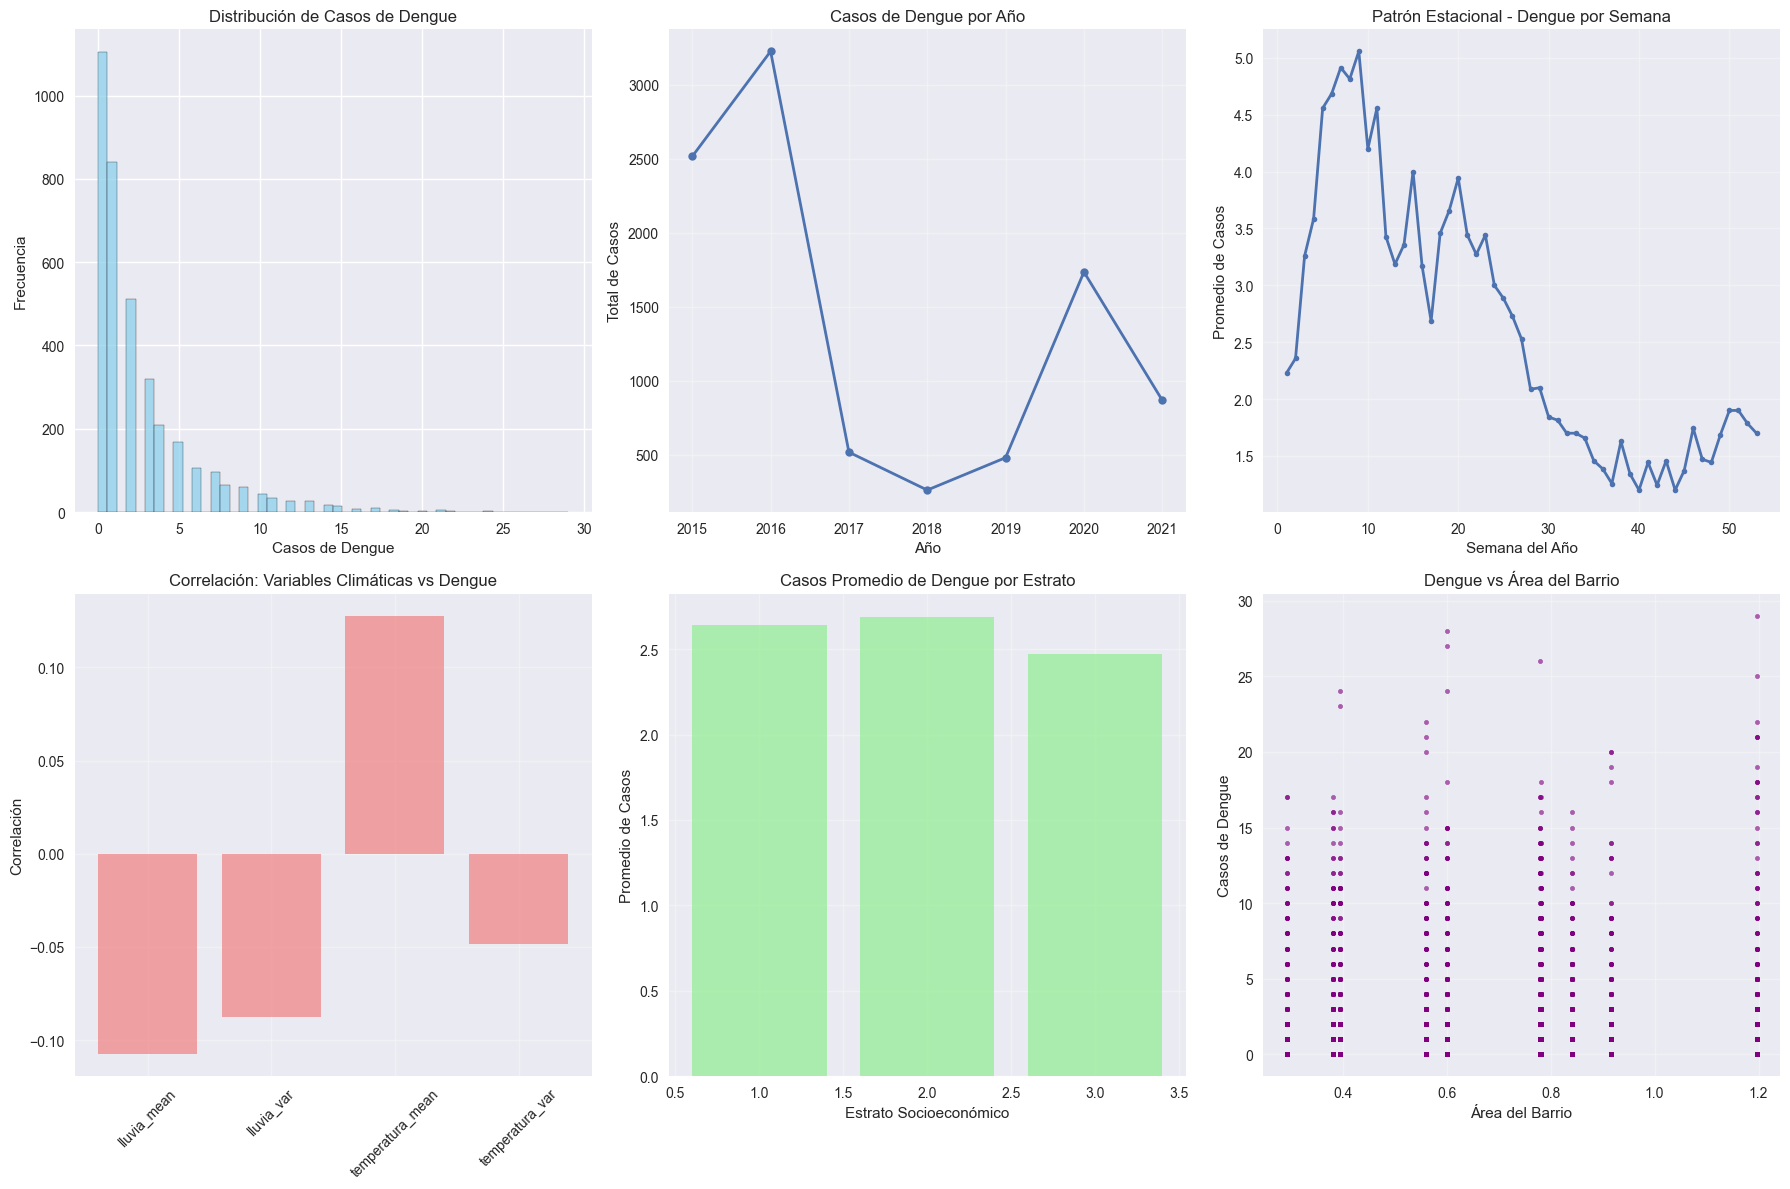

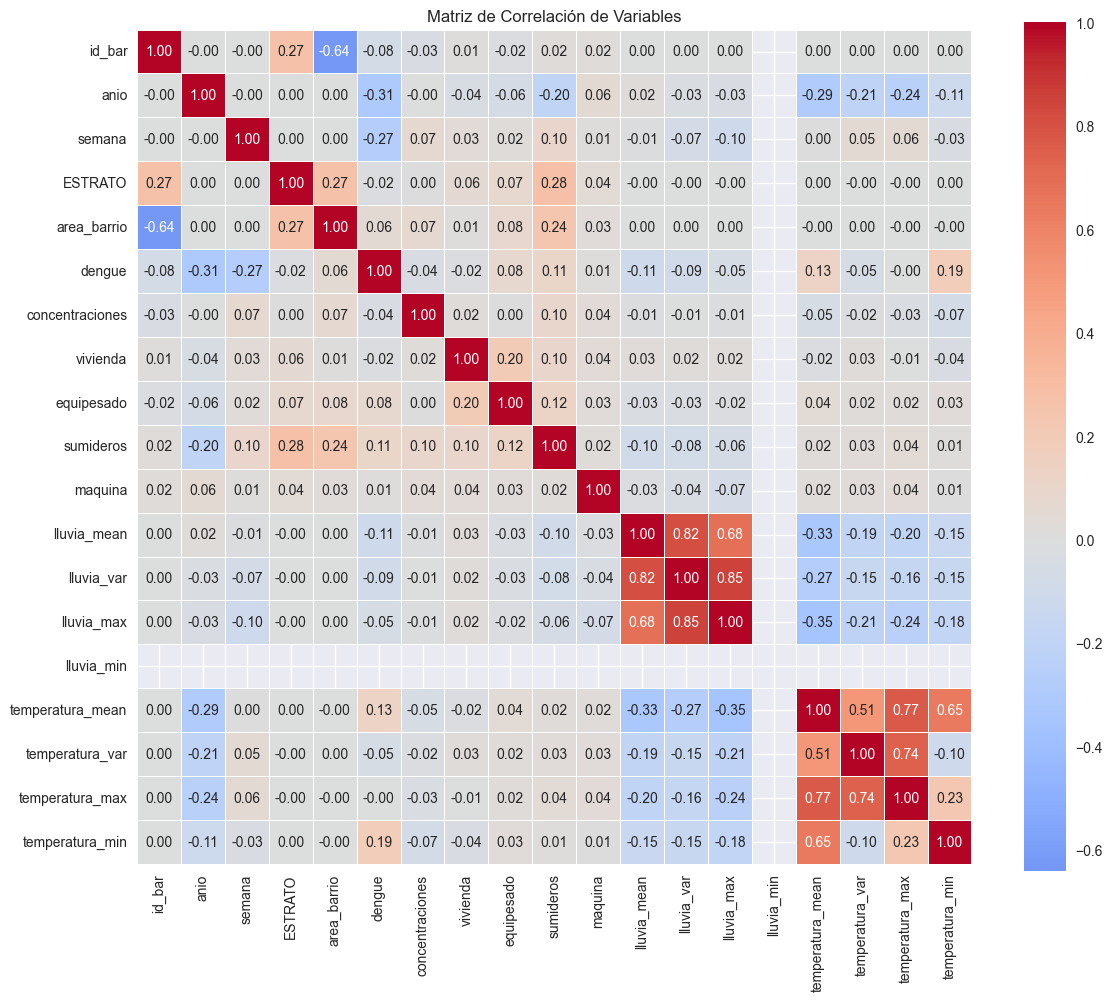

[I 2025-06-29 17:18:49,031] A new study created in memory with name: no-name-550aff26-daad-465f-836c-7ee380ca3b5b



=== INICIANDO PREPROCESAMIENTO ===
Características seleccionadas: 31
Características: ['id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina']...

=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===


[W 2025-06-29 17:22:06,229] Trial 0 failed with parameters: {'sequence_length': 12, 'ch1': 62, 'ch2': 103, 'ch3': 179, 'kernel_size': 2, 'dropout': 0.16239780813448107, 'hidden_size': 37, 'learning_rate': 0.005399484409787433, 'batch_size': 45} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Git\ICESI\FAII_TALLER2_FINAL\FA_TALLER2\venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\usuario\AppData\Local\Temp\ipykernel_29700\2405738864.py", line 521, in objective
    model, _, _ = train_model(model, train_loader, val_loader,
                  ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                            num_epochs=50, learning_rate=learning_rate, device=device)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\usuario\AppData\Local\Temp\ipykernel_29700\2405738864.py", line 390, in train_model
    out

KeyboardInterrupt: 

In [ ]:
# Pronóstico de Dengue usando Temporal Convolutional Network (TCN)
# Análisis exploratorio de datos y modelo completo con PyTorch y Optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import optuna
from optuna.trial import TrialState
from typing import Tuple, List
import random
from tqdm import tqdm

# Configuración de seeds para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# ========================================================================================
# 1. CARGA Y ANÁLISIS EXPLORATORIO DE DATOS
# ========================================================================================

print("=== CARGANDO DATOS ===")
df_train = pd.read_parquet('../../Datos/df_train.parquet')
df_test = pd.read_parquet('../../Datos/df_test.parquet')

print(f"Datos de entrenamiento: {df_train.shape}")
print(f"Datos de prueba: {df_test.shape}")
print(f"\nColumnas: {list(df_train.columns)}")

# Información básica de los datasets
print("\n=== INFORMACIÓN BÁSICA ===")
print(f"Rango de años - Train: {df_train['anio'].min()} - {df_train['anio'].max()}")
print(f"Rango de años - Test: {df_test['anio'].min()} - {df_test['anio'].max()}")
print(f"Número de barrios únicos en train: {df_train['id_bar'].nunique()}")
print(f"Número de barrios únicos en test: {df_test['id_bar'].nunique()}")
print(f"Rango de semanas: {df_train['semana'].min()} - {df_train['semana'].max()}")

# Estadísticas de la variable objetivo
print("\n=== ESTADÍSTICAS DE LA VARIABLE OBJETIVO (DENGUE) ===")
print(df_train['dengue'].describe())
print(f"Valores faltantes en dengue: {df_train['dengue'].isnull().sum()}")

# Análisis de valores faltantes
print("\n=== VALORES FALTANTES ===")
missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()
print("Train:")
print(missing_train[missing_train > 0])
print("\nTest:")
print(missing_test[missing_test > 0])

# ========================================================================================
# 2. VISUALIZACIONES EXPLORATORIAS
# ========================================================================================

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de dengue
axes[0,0].hist(df_train['dengue'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribución de Casos de Dengue')
axes[0,0].set_xlabel('Casos de Dengue')
axes[0,0].set_ylabel('Frecuencia')

# Casos de dengue por año
yearly_dengue = df_train.groupby('anio')['dengue'].sum()
axes[0,1].plot(yearly_dengue.index, yearly_dengue.values, marker='o', linewidth=2, markersize=6)
axes[0,1].set_title('Casos de Dengue por Año')
axes[0,1].set_xlabel('Año')
axes[0,1].set_ylabel('Total de Casos')
axes[0,1].grid(True, alpha=0.3)

# Casos de dengue por semana (patrón estacional)
weekly_dengue = df_train.groupby('semana')['dengue'].mean()
axes[0,2].plot(weekly_dengue.index, weekly_dengue.values, marker='o', linewidth=2, markersize=4)
axes[0,2].set_title('Patrón Estacional - Dengue por Semana')
axes[0,2].set_xlabel('Semana del Año')
axes[0,2].set_ylabel('Promedio de Casos')
axes[0,2].grid(True, alpha=0.3)

# Correlación entre variables climáticas y dengue
climate_vars = ['lluvia_mean', 'lluvia_var', 'temperatura_mean', 'temperatura_var']
correlations = df_train[climate_vars + ['dengue']].corr()['dengue'][:-1]
axes[1,0].bar(range(len(correlations)), correlations.values, color='lightcoral', alpha=0.7)
axes[1,0].set_title('Correlación: Variables Climáticas vs Dengue')
axes[1,0].set_xticks(range(len(correlations)))
axes[1,0].set_xticklabels(correlations.index, rotation=45)
axes[1,0].set_ylabel('Correlación')
axes[1,0].grid(True, alpha=0.3)

# Dengue por estrato socioeconómico
strata_dengue = df_train.groupby('ESTRATO')['dengue'].mean()
axes[1,1].bar(strata_dengue.index, strata_dengue.values, color='lightgreen', alpha=0.7)
axes[1,1].set_title('Casos Promedio de Dengue por Estrato')
axes[1,1].set_xlabel('Estrato Socioeconómico')
axes[1,1].set_ylabel('Promedio de Casos')
axes[1,1].grid(True, alpha=0.3)

# Dengue vs área del barrio
axes[1,2].scatter(df_train['area_barrio'], df_train['dengue'], alpha=0.6, color='purple', s=10)
axes[1,2].set_title('Dengue vs Área del Barrio')
axes[1,2].set_xlabel('Área del Barrio')
axes[1,2].set_ylabel('Casos de Dengue')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
correlation_matrix = df_train[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Matriz de Correlación de Variables')
plt.tight_layout()
plt.show()

# ========================================================================================
# 3. PREPROCESAMIENTO DE DATOS
# ========================================================================================

class DataPreprocessor:
    def __init__(self):
        self.scalers = {}
        self.label_encoders = {}
        self.feature_columns = None
        
    def prepare_features(self, df):
        """Prepara las características para el modelo"""
        df = df.copy()
        
        # Crear características temporales
        df['mes'] = ((df['semana'] - 1) // 4) + 1  # Aproximación de mes
        df['trimestre'] = ((df['semana'] - 1) // 13) + 1
        df['sin_semana'] = np.sin(2 * np.pi * df['semana'] / 52)
        df['cos_semana'] = np.cos(2 * np.pi * df['semana'] / 52)
        
        # Características de interacción
        df['lluvia_temp'] = df['lluvia_mean'] * df['temperatura_mean']
        df['lluvia_area'] = df['lluvia_mean'] * df['area_barrio']
        df['temp_area'] = df['temperatura_mean'] * df['area_barrio']
        
        # Características de lag para variables climáticas (si hay suficientes datos)
        for col in ['lluvia_mean', 'temperatura_mean']:
            if len(df) > 4:
                df[f'{col}_lag1'] = df.groupby('id_bar')[col].shift(1)
                df[f'{col}_lag2'] = df.groupby('id_bar')[col].shift(2)
                # Corregir el cálculo de media móvil para evitar problemas de índice
                df = df.sort_values(['id_bar', 'anio', 'semana'])
                df[f'{col}_ma3'] = df.groupby('id_bar')[col].transform(
                    lambda x: x.rolling(window=3, min_periods=1).mean()
                )
        
        return df
    
    def fit_transform(self, df):
        """Ajusta los escaladores y transforma los datos"""
        df = self.prepare_features(df)
        
        # Seleccionar características numéricas (excluyendo id y target)
        exclude_cols = ['id', 'dengue', '__index_level_0__']
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        self.feature_columns = [col for col in numeric_cols if col not in exclude_cols]
        
        # Escalar características numéricas
        scaler = StandardScaler()
        df_scaled = df.copy()
        df_scaled[self.feature_columns] = scaler.fit_transform(df[self.feature_columns].fillna(0))
        self.scalers['features'] = scaler
        
        # Escalar target si existe
        if 'dengue' in df.columns:
            target_scaler = StandardScaler()
            df_scaled['dengue_scaled'] = target_scaler.fit_transform(df[['dengue']].fillna(0))
            self.scalers['target'] = target_scaler
        
        return df_scaled
    
    def transform(self, df):
        """Transforma nuevos datos usando escaladores ajustados"""
        df = self.prepare_features(df)
        df_scaled = df.copy()
        
        # Transformar características
        df_scaled[self.feature_columns] = self.scalers['features'].transform(
            df[self.feature_columns].fillna(0)
        )
        
        return df_scaled

# ========================================================================================
# 4. DATASET PERSONALIZADO PARA SERIES TEMPORALES
# ========================================================================================

class DengueTimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=12, target_col='dengue_scaled', 
                 feature_cols=None, is_train=True):
        self.data = data.copy()
        self.sequence_length = sequence_length
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.is_train = is_train
        
        # Agrupar por id_bar y ordenar por semana
        self.data = self.data.sort_values(['id_bar', 'anio', 'semana'])
        self.grouped_data = self.data.groupby('id_bar')
        
        # Crear secuencias
        self.sequences = []
        self.targets = []
        self.metadata = []
        
        for id_bar, group in self.grouped_data:
            group = group.reset_index(drop=True)
            
            if len(group) >= sequence_length + (1 if is_train else 0):
                for i in range(len(group) - sequence_length + (0 if is_train else 1)):
                    # Secuencia de características
                    seq_data = group.iloc[i:i+sequence_length][feature_cols].values
                    self.sequences.append(seq_data)
                    
                    # Target (solo para entrenamiento)
                    if is_train and i + sequence_length < len(group):
                        target = group.iloc[i+sequence_length][target_col]
                        self.targets.append(target)
                    elif not is_train:
                        # Para predicción, usar el último valor disponible como placeholder
                        target = 0.0
                        self.targets.append(target)
                    
                    # Metadata para identificación
                    if is_train and i + sequence_length < len(group):
                        meta = group.iloc[i+sequence_length][['id_bar', 'anio', 'semana']]
                    else:
                        meta = group.iloc[i+sequence_length-1][['id_bar', 'anio', 'semana']]
                    self.metadata.append(meta)
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        
        return sequence, target

# ========================================================================================
# 5. IMPLEMENTACIÓN DE TEMPORAL CONVOLUTIONAL NETWORK (TCN)
# ========================================================================================

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
        
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation_size,
                                   padding=(kernel_size-1) * dilation_size, 
                                   dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class DengueTCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2, 
                 hidden_size=50, output_size=1):
        super(DengueTCN, self).__init__()
        
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout)
        self.fc = nn.Sequential(
            nn.Linear(num_channels[-1], hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        # TCN expects: (batch_size, features, seq_len)
        x = x.transpose(1, 2)
        
        # Pasar por TCN
        tcn_out = self.tcn(x)
        
        # Tomar la última salida temporal
        out = tcn_out[:, :, -1]
        
        # Pasar por capas fully connected
        out = self.fc(out)
        
        return out.squeeze()

# ========================================================================================
# 6. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# ========================================================================================

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Entrena el modelo TCN"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.5, patience=10)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validación
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch+1}")
            break
    
    # Cargar el mejor modelo
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

def evaluate_model(model, data_loader, device, scaler=None):
    """Evalúa el modelo"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            predictions.extend(output.cpu().numpy())
            actuals.extend(target.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Desescalar si es necesario
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        actuals = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calcular métricas
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

# ========================================================================================
# 7. OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA
# ========================================================================================

def objective(trial):
    """Función objetivo para Optuna"""
    
    # Hiperparámetros a optimizar
    sequence_length = trial.suggest_int('sequence_length', 8, 20)
    num_channels = [
        trial.suggest_int('ch1', 16, 64),
        trial.suggest_int('ch2', 32, 128),
        trial.suggest_int('ch3', 64, 256)
    ]
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    
    try:
        # Preparar datos
        preprocessor = DataPreprocessor()
        df_train_processed = preprocessor.fit_transform(df_train)
        
        # Crear datasets
        train_dataset = DengueTimeSeriesDataset(
            df_train_processed, 
            sequence_length=sequence_length,
            target_col='dengue_scaled',
            feature_cols=preprocessor.feature_columns,
            is_train=True
        )
        
        # Split temporal para validación
        split_idx = int(0.8 * len(train_dataset))
        train_subset = torch.utils.data.Subset(train_dataset, range(split_idx))
        val_subset = torch.utils.data.Subset(train_dataset, range(split_idx, len(train_dataset)))
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Crear modelo
        model = DengueTCN(
            input_size=len(preprocessor.feature_columns),
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            hidden_size=hidden_size
        )
        
        # Entrenar modelo
        model, _, _ = train_model(model, train_loader, val_loader, 
                                num_epochs=50, learning_rate=learning_rate, device=device)
        
        # Evaluar
        results = evaluate_model(model, val_loader, device)
        return results['rmse']
        
    except Exception as e:
        print(f"Error en trial: {e}")
        return float('inf')

# ========================================================================================
# 8. PIPELINE PRINCIPAL
# ========================================================================================

print("\n=== INICIANDO PREPROCESAMIENTO ===")

# Preprocesar datos
preprocessor = DataPreprocessor()
df_train_processed = preprocessor.fit_transform(df_train)
df_test_processed = preprocessor.transform(df_test)

print(f"Características seleccionadas: {len(preprocessor.feature_columns)}")
print(f"Características: {preprocessor.feature_columns[:10]}...")  # Mostrar primeras 10

# ========================================================================================
# 9. OPTIMIZACIÓN DE HIPERPARÁMETROS
# ========================================================================================

print("\n=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===")

# Configurar Optuna
study = optuna.create_study(direction='minimize', 
                           sampler=optuna.samplers.TPESampler(seed=42))

# Ejecutar optimización
n_trials = 20  # Reducido para ejemplo, aumentar para mejor resultado
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)  

print(f"Mejor trial: {study.best_trial.number}")
print(f"Mejor RMSE: {study.best_value:.4f}")
print(f"Mejores hiperparámetros: {study.best_trial.params}")

# ========================================================================================
# 10. ENTRENAMIENTO DEL MODELO FINAL
# ========================================================================================

print("\n=== ENTRENAMIENTO DEL MODELO FINAL ===")

# Usar mejores hiperparámetros
best_params = study.best_trial.params

# Crear dataset final
train_dataset = DengueTimeSeriesDataset(
    df_train_processed,
    sequence_length=best_params['sequence_length'],
    target_col='dengue_scaled',
    feature_cols=preprocessor.feature_columns,
    is_train=True
)

# Split temporal
split_idx = int(0.8 * len(train_dataset))
train_subset = torch.utils.data.Subset(train_dataset, range(split_idx))
val_subset = torch.utils.data.Subset(train_dataset, range(split_idx, len(train_dataset)))

train_loader = DataLoader(train_subset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_subset, batch_size=best_params['batch_size'], shuffle=False)

# Crear modelo final
final_model = DengueTCN(
    input_size=len(preprocessor.feature_columns),
    num_channels=[best_params['ch1'], best_params['ch2'], best_params['ch3']],
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout'],
    hidden_size=best_params['hidden_size']
)

# Entrenar modelo final
final_model, train_losses, val_losses = train_model(
    final_model, train_loader, val_loader,
    num_epochs=100,
    learning_rate=best_params['learning_rate'],
    device=device
)

# Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Curvas de Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Evaluar modelo final
results = evaluate_model(final_model, val_loader, device, preprocessor.scalers['target'])

plt.subplot(1, 2, 2)
plt.scatter(results['actuals'], results['predictions'], alpha=0.6, s=10)
plt.plot([results['actuals'].min(), results['actuals'].max()], 
         [results['actuals'].min(), results['actuals'].max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Predicciones vs Reales (R² = {results["r2"]:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMétricas del modelo final:")
print(f"RMSE: {results['rmse']:.4f}")
print(f"MAE: {results['mae']:.4f}")
print(f"R²: {results['r2']:.4f}")

# ========================================================================================
# 11. PREDICCIONES PARA 2022
# ========================================================================================

print("\n=== GENERANDO PREDICCIONES PARA 2022 ===")

# Crear dataset de test
test_dataset = DengueTimeSeriesDataset(
    df_test_processed,
    sequence_length=best_params['sequence_length'],
    target_col='dengue_scaled',  # No se usa para predicción
    feature_cols=preprocessor.feature_columns,
    is_train=False
)

test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Generar predicciones
final_model.eval()
predictions_scaled = []
metadata_list = []

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        output = final_model(data)
        predictions_scaled.extend(output.cpu().numpy())
        
        # Obtener metadata correspondiente
        start_idx = i * best_params['batch_size']
        end_idx = min((i + 1) * best_params['batch_size'], len(test_dataset))
        for j in range(start_idx, end_idx):
            metadata_list.append(test_dataset.metadata[j])

# Desescalar predicciones
predictions = preprocessor.scalers['target'].inverse_transform(
    np.array(predictions_scaled).reshape(-1, 1)
).flatten()

# Asegurar que las predicciones no sean negativas
predictions = np.maximum(predictions, 0)

# ========================================================================================
# 12. CREAR ARCHIVO DE SALIDA
# ========================================================================================

print("\n=== CREANDO ARCHIVO DE SALIDA ===")

# Crear DataFrame con resultados
results_df = pd.DataFrame(metadata_list)
results_df['dengue'] = np.round(predictions, 2)

# Crear columna id en el formato requerido
results_df['id'] = (results_df['id_bar'].astype(str) + '_' + 
                   results_df['anio'].astype(str) + '_' + 
                   results_df['semana'].astype(str).str.zfill(2))

# Seleccionar solo las columnas requeridas
output_df = results_df[['id', 'dengue']].copy()

# Mostrar estadísticas de las predicciones
print(f"Número de predicciones: {len(output_df)}")
print(f"Rango de predicciones: {output_df['dengue'].min():.2f} - {output_df['dengue'].max():.2f}")
print(f"Promedio de predicciones: {output_df['dengue'].mean():.2f}")

# Mostrar primeras filas
print("\nPrimeras predicciones:")
print(output_df.head(10))

# Guardar archivo
output_df.to_csv('dengue_predictions_2022.csv', index=False)
print("\nArchivo guardado como 'dengue_predictions_2022.csv'")

# Mostrar distribución de predicciones por semana
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
weekly_pred = results_df.groupby('semana')['dengue'].mean()
plt.plot(weekly_pred.index, weekly_pred.values, marker='o', linewidth=2, markersize=4)
plt.title('Predicciones Promedio por Semana - 2022')
plt.xlabel('Semana del Año')
plt.ylabel('Casos Promedio Predichos')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(output_df['dengue'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Distribución de Predicciones de Dengue 2022')
plt.xlabel('Casos Predichos')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== ANÁLISIS COMPLETADO ===")
print("El modelo TCN ha sido entrenado y optimizado exitosamente.")
print("Las predicciones para 2022 han sido generadas y guardadas.")